### Natural Language Processing - Text Classification using Seinfeld Transcript Data

##### 0 - Setting up required imports, importing data, and cleaning data.

In [1]:
## for data
import pandas as pd
import numpy as np
from itertools import chain

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk
import wordcloud

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics, feature_selection

## for explainer
from lime import lime_text

## for word embedding (Word2Vec)
import gensim
from gensim.models import Word2Vec

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

In [2]:
# read the generated transcripts CSV from Data Scraper ipynb
seinfeldDF = pd.read_csv('seinfeld_transcripts.csv')

In [3]:
# Some Data Cleaning
# transpose the data frame
seinfeldDFT = seinfeldDF.T
# ravel the data frame aka put all columns into one centralized column, drop na's, lower case
cleanedDF = pd.Series(seinfeldDFT.values.ravel('F')).dropna()
cleanedDF = cleanedDF.to_frame(name='Character')
cleanedDF['Character'] = cleanedDF['Character'].str.lower()

# separate the character from the text and keep the 4 most popular
cleanedDF[['Character','Character Text']] = cleanedDF["Character"].str.split(":", 1, expand=True)
cleanedDF = cleanedDF.dropna()

##### 1 - Text Analysis and Cleaning

In [4]:
# lets take a look at the distribution of characters and their lines
cleanedDF.Character.str.split(expand=True).stack().value_counts()

jerry          9723
george         6494
elaine         5267
kramer         4335
newman          459
               ... 
#135              1
(two              1
(heretofore       1
november          1
talk              1
Length: 2386, dtype: int64

Unsurprisingly, Jerry has the most lines followed by George, Elaine, and Kramer. We will use these 4 characters as our primary predictor targets.
Next I clean the data to only include these characters and remove the text in parenthesis (not spoken by the character)

In [5]:
# clean character col for jerry, george, elaine, and kramer
cleanedDF = cleanedDF[(cleanedDF['Character'] == 'jerry') 
                      | (cleanedDF['Character'] == 'george') 
                      | (cleanedDF['Character'] == 'elaine') 
                      | (cleanedDF['Character'] == 'kramer')]

# clean character text from brackets, characters do not say these lines
cleanedDF['Character Text'] = cleanedDF['Character Text'].str.replace(r"\[.*\]","")
cleanedDF['Character Text'] = cleanedDF['Character Text'].str.replace(r"\(.*\)","")
cleanedDF.sample(5)

<ipython-input-5-b8cb78b855a7>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  cleanedDF['Character Text'] = cleanedDF['Character Text'].str.replace(r"\[.*\]","")
<ipython-input-5-b8cb78b855a7>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  cleanedDF['Character Text'] = cleanedDF['Character Text'].str.replace(r"\(.*\)","")


,Character,Character Text
62266,george,$2? but everyone in front of me got free bread.
67768,elaine,"no, you better gimme back that bike. newman,"
36101,george,"no-no-no, kramer. kramer! kramer! you *cannot..."
78715,jerry,"technically, you're sauted. so, what are you ..."
44034,kramer,you're *not*!!!


In [6]:
cleanedDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24777 entries, 21738 to 86925
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Character       24777 non-null  object
 1   Character Text  24777 non-null  object
dtypes: object(2)
memory usage: 580.7+ KB


<AxesSubplot:>

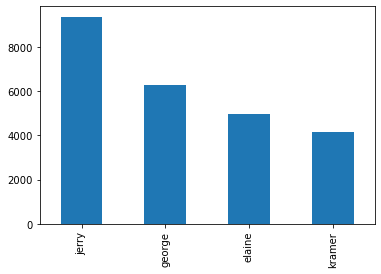

In [7]:
cleanedDF.Character.value_counts().plot(kind='bar')

In [8]:
cleanedDF.Character.value_counts()

jerry     9358
george    6263
elaine    4989
kramer    4167
Name: Character, dtype: int64

##### 2 - Pre-processing
In this step, the character text col will be modified by tokenization, removal of stop words, stemming, and lemmatization. source: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [9]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text


In [10]:
# download NLTK data, un-comment this out if you don't have it
# nltk.download('wordnet')
# nltk.download('stopwords')
# obtain stopwords
lst_stopwords = nltk.corpus.stopwords.words("english")
cleanedDF["Character Text_clean"] = cleanedDF["Character Text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
cleanedDF.head()

,Character,Character Text,Character Text_clean
21738,jerry,"you know, why we're here? ""he didn't tell me...",know didnt tell going must gone wanna go get r...
21741,jerry,"seems to me, that button is in the worst poss...",seems button worst possible spot second button...
21742,george,are you through?,
21743,jerry,"you do of course try on, when you buy?",course try buy
21744,george,"yes, it was purple, i liked it, i don't actua...",yes purple liked dont actually recall consider...


In [11]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(cleanedDF, test_size=0.3)
## get target
y_train = dtf_train["Character"].values
y_test = dtf_test["Character"].values

##### 3 - Baseline Model

Feature Engineering: use tf-idf vectorizer to extract info from the data

Text(0.5, 1.0, 'Sparse Matrix Sample')

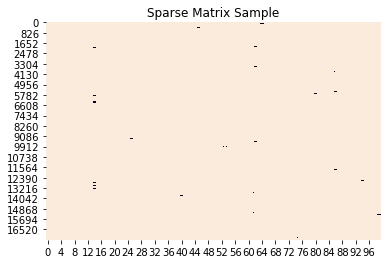

In [12]:
## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

corpus = dtf_train["Character Text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, 
            cbar=False).set_title('Sparse Matrix Sample')

The matrix is fairly sparse, we can reduce dimensionality with feature selection.
We can treat each category as binary and do a Chi-Square test to determine whether a feature and the (binary) target are independent

In [13]:
y = dtf_train["Character"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [14]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# elaine:
  . selected features: 276
  . top features: um,bike,lippman,mr pitt,mr peterman,pitt,peterman,hi,mr,aaron
 
# george:
  . selected features: 208
  . top features: moops,seven,yeah,bozo,sir,kimbrough,newman,course,mr morgan,architect
 
# jerry:
  . selected features: 65
  . top features: jerry,uh,leo,hello newman,elaine,youre,mr,ha,dunno,town
 
# kramer:
  . selected features: 450
  . top features: buddy,hey,yeah,hey buddy,hey jerry,jerry,oh hey,woah,mama,meat
 


Text(0.5, 1.0, 'Sparse Matrix Sample')

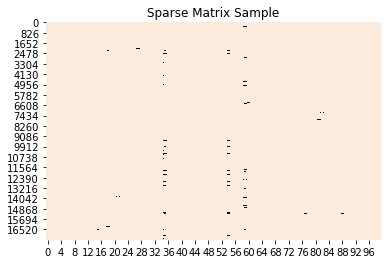

In [15]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')


The martix is now a little less sparse

##### Naive Bayes Model

In [16]:
classifier = naive_bayes.MultinomialNB()

In [17]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["Character Text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.41
Auc: 0.59
Detail:
              precision    recall  f1-score   support

      elaine       0.42      0.08      0.14      1489
      george       0.41      0.12      0.18      1877
       jerry       0.40      0.91      0.56      2826
      kramer       0.50      0.09      0.16      1242

    accuracy                           0.41      7434
   macro avg       0.43      0.30      0.26      7434
weighted avg       0.42      0.41      0.31      7434



(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'elaine'),
  Text(0, 1.5, 'george'),
  Text(0, 2.5, 'jerry'),
  Text(0, 3.5, 'kramer')])

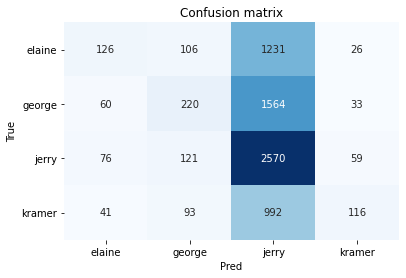

In [18]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)


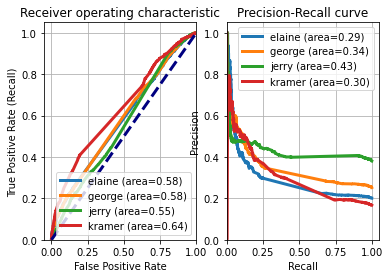

In [19]:
## Plot roc
fig, ax = plt.subplots(nrows=1, ncols=2)

for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

The model is able to produce accuracy of 40%, which is higher than the baseline of randomly guessing (25%) and blindly guessing Jerry for all characters (37.8%).

##### BERT